# Imports

In [11]:
import os
#import cv2
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import numpy as np
import torch.nn as nn
import torch.optim as optim
import re
import matplotlib.pyplot as plt

# Global

In [ ]:
#transformations for the dataset
transform = transforms.Compose([
    transforms.Resize((256, 256)), # Resize to a fixed size
    #transforms.ColorJitter(brightness=0.2, contrast=0.2), # Augmentation, DUNNO ABOUT THIS, MAYBE LATER
    transforms.ToTensor(), # Convert image to PyTorch tensor
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]), # Normalize the image to have mean 0.5 and std 0.5
    #transforms.Grayscale(num_output_channels=1), #allows the model to focus on plate numbers without color distraction
    #transforms.RandomRotation(degrees=3), # small tilt to simulate real-world scenarios, already present, commenting for now
    #transforms.RandomPerspective(distortion_scale=0.2, p=0.5) #this as well, to simulate real world random perspective distortions. have to check other dataset folders, maybe already present
])


#saving fields of the licence plate as global variables, i'm gonna use them later on
provinces = ["皖", "沪", "津", "渝", "冀", "晋", "蒙", "辽", "吉", "黑", "苏", "浙", "京", "闽", "赣", "鲁", "豫", "鄂", "湘", "粤", "桂", "琼", "川", "贵", "云", "藏", "陕", "甘", "青", "宁", "新", "警", "学", "O"]
alphabets = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'J', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'O']
ads = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'J', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'O']


MY_DICTIONARY = provinces + [c for c in alphabets if c not in provinces] + [c for c in ads if c not in provinces and c not in alphabets]    #basically not to add three times "O"
MY_DICTIONARY = list(dict.fromkeys(MY_DICTIONARY))  # Remove duplicates while preserving order
# Create character to index and index to character mappings
char2idx = {c: i for i, c in enumerate(MY_DICTIONARY)}
idx2char = {i: c for i, c in enumerate(MY_DICTIONARY)}
BLANK_IDX = len(MY_DICTIONARY)  # CTC needs +1 for "blank" , so keep the len

# Utils

In [ ]:
class CRNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(3, 64, 3, 1, 1), nn.ReLU(),           #CHANGED TO 3 MODELS TO TRY !!!!!!!!!! HERE
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, 3, 1, 1), nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(128, 256, 3, 1, 1), nn.ReLU(),
            nn.AdaptiveAvgPool2d((1, None))  # (height=1, width stays)
        )
        self.rnn = nn.LSTM(256, 128, num_layers=2, bidirectional=True)
        self.fc = nn.Linear(128*2, num_classes)  # bidirectional

    def forward(self, x):
        x = self.cnn(x)  # [B, C, 1, W]
        x = x.squeeze(2) # [B, C, W]
        x = x.permute(2, 0, 1)  # [W, B, C]
        x, _ = self.rnn(x)
        x = self.fc(x)  # [W, B, num_classes]
        return x  # output for CTC: [seq_len, batch, num_classes]
    


def ctc_collate_fn(batch):
    '''
    basically what I do here is stacking all the images in a batch into a single tensor and
    then computing the len of each label (assuming different lenght plate can happen).
    Finally just concatenating all the labels into a vector (pytorch CTC wantres them in a line, not list)
    then returning image-label-its lenght.
    I need this to tell CTC where labels finish and i do not care padding as CTC deals with that internally (NICE)

    '''
    images, labels = zip(*batch)
    images = torch.stack(images)
    label_lengths = torch.tensor([len(l) for l in labels], dtype=torch.long)
    labels = torch.cat(labels)
    return images, labels, label_lengths


def train_one_epoch(model, dataloader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    for images, labels, label_lengths in dataloader:
        images = images.to(device)
        labels = labels.to(device)
        label_lengths = label_lengths.to(device)
        optimizer.zero_grad()
        outputs = model(images)  # [W, B, num_classes]
        log_probs = outputs.log_softmax(2)
        input_lengths = torch.full(size=(images.size(0),), fill_value=log_probs.size(0), dtype=torch.long).to(device)
        loss = criterion(log_probs, labels, input_lengths, label_lengths)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    avg_loss = total_loss / len(dataloader)
    print(f"Epoch average loss: {avg_loss:.4f}")
    return avg_loss


def ctc_greedy_decoder(output, idx2char, blank=BLANK_IDX):
    '''
    Now, I know the network returns probabilities, as it does a softmax with logits of characters.
    I need to transform that probability into an actual char to compose the plate.
    I take the argmax of the softmax (most prob char), remove blanks used by CTC and possible
    duplicates CTC can actually produce.
    At the end I simply use the  mappings char-index index-char deefined at the beginning to compose the plate.
    This is greedy as it just takes the argmax of every step, I think it's more than enough here.
    '''
    # output: [seq_len, batch, num_classes]
    out = output.permute(1, 0, 2)  # [batch, seq_len, num_classes]
    pred_strings = []
    for probs in out:
        pred = probs.argmax(1).cpu().numpy()
        #
        prev = -1
        pred_str = []
        for p in pred:
            if p != blank and p != prev:
                pred_str.append(idx2char[p])
            prev = p
        pred_strings.append(''.join(pred_str))
    return pred_strings


'''def evaluate(model, dataloader, device):
    model.eval()
    total = 0
    correct = 0
    with torch.no_grad():   #classic stuff to speed it up, no need to compute gradients
        for images, labels, label_lengths in dataloader:
            images = images.to(device)
            outputs = model(images)
            pred_strings = ctc_greedy_decoder(outputs, idx2char)
            # Ricostruisci le targhe vere
            labels_cpu = labels.cpu().numpy()
            lengths_cpu = label_lengths.cpu().numpy()
            idx = 0
            gt_strings = []
            for l in lengths_cpu:
                gt = ''.join([idx2char[i] for i in labels_cpu[idx:idx+l]])
                gt_strings.append(gt)
                idx += l
            for pred, gt in zip(pred_strings, gt_strings):
                if pred == gt:
                    correct += 1
                total += 1
    acc = correct / total
    print(f"Eval accuracy (full plate): {acc:.4f}")
    return acc'''

def evaluate(model, dataloader, device):
    model.eval()
    total = 0
    correct = 0
    total_chars = 0
    correct_chars = 0
    with torch.no_grad():
        for images, labels, label_lengths in dataloader:
            images = images.to(device)
            outputs = model(images)
            pred_strings = ctc_greedy_decoder(outputs, idx2char)
            labels_cpu = labels.cpu().numpy()   #need to move tensors tu cpu memory for numpy
            lengths_cpu = label_lengths.cpu().numpy()
            idx = 0
            gt_strings = []
            for l in lengths_cpu:
                gt = ''.join([idx2char[i] for i in labels_cpu[idx:idx+l]])
                gt_strings.append(gt)
                idx += l
            for pred, gt in zip(pred_strings, gt_strings):
                if pred == gt:
                    correct += 1
                total += 1
                # Character-level accuracy, had to introduce this cause train is very slow.
                # Need to know if at least model's getting some chars
                min_len = min(len(pred), len(gt))
                correct_chars += sum([p == g for p, g in zip(pred[:min_len], gt[:min_len])])
                total_chars += len(gt)
    acc = correct / total
    acc_char = correct_chars / total_chars
    print(f"Eval accuracy (full plate): {acc:.4f} | Char accuracy: {acc_char:.4f}")
    return acc, acc_char

# Data

A sample image name is "025-95_113-154&383_386&473-386&473_177&454_154&383_363&402-0_0_22_27_27_33_16-37-15.jpg".
Each name can be splited by "-" into seven fields. Those fields are explained as follows.

1) Area: Area ratio of license plate area to the entire picture area.

2) Tilt degree: Horizontal tilt degree and vertical tilt degree.

3) Bounding box coordinates: The coordinates of the left-up and the right-bottom vertices.

4) Four vertices locations: The exact (x, y) coordinates of the four vertices of LP in the whole image. These coordinates start from the right-bottom vertex.

5) License plate number: Each image in CCPD has only one LP. Each LP number is comprised of a Chinese character, a letter, and five letters or numbers. A valid Chinese license plate consists of seven characters:

       - province (1 character),
       - alphabets (1 character),
       - alphabets+digits (5 characters).

"0_0_22_27_27_33_16" is the index of each character. These three arrays are defined as follows. The last character of each array is letter O rather than a digit 0. We use O as a sign of "no character" because there is no O in Chinese license plate characters.

provinces = ["皖", "沪", "津", "渝", "冀", "晋", "蒙", "辽", "吉", "黑", "苏", "浙", "京", "闽", "赣", "鲁", "豫", "鄂", "湘", "粤", "桂", "琼", "川", "贵", "云", "藏", "陕", "甘", "青", "宁", "新", "警", "学", "O"]


alphabets = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'J', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W',
             'X', 'Y', 'Z', 'O']


ads = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'J', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X',
       'Y', 'Z', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'O']


6) Brightness: The brightness of the license plate region.

7) Blurriness: The Blurriness of the license plate region.

In [43]:
class CarPlateDataset(Dataset):

    def __init__(self, img_dir, transform=None, cropped = False):
        self.img_dir = img_dir
        self.transform = transform
        self.image_names = os.listdir(img_dir)
        self.cropped = cropped


    def __len__(self):
        return len(self.image_names)

    def parse_filename(self, filename):
        fields = filename.split('-')
        area = float(fields[0]) / 100  #filename encodes the area in percentage (ratio plate-no plate area), so divising by 100 gives me a 0-1 range
        tilt_degree = fields[1].split('_')
        h_tilt = int(tilt_degree[0])    #horizontal tilt degree
        v_tilt = int(tilt_degree[1])    #vertical tilt degree
        tilt_list = np.array([h_tilt, v_tilt], dtype=np.float32)


        bbox_coords = fields[2].split('_')  #buonding box coordinates
        leftUp_bbox = bbox_coords[0].split('&')
        leftUp_bbox_x = int(leftUp_bbox[0])
        leftUp_bbox_y = int(leftUp_bbox[1])
        rightBottom_bbox = bbox_coords[1].split('&')
        rightDown_bbox_x = int(rightBottom_bbox[0])
        rightDown_bbox_y = int(rightBottom_bbox[1])
        bbox_coords_list = np.array([(leftUp_bbox_x, leftUp_bbox_y),
                                    (rightDown_bbox_x, rightDown_bbox_y)], dtype=np.float32)

        vertices = fields[3].split('_')  #vertices of the plate
        left_bottom_vertex = vertices[0].split('&')
        left_bottom_vertex_x = int(left_bottom_vertex[0])
        left_bottom_vertex_y = int(left_bottom_vertex[1])
        right_bottom_vertex = vertices[1].split('&')
        right_bottom_vertex_x = int(right_bottom_vertex[0])
        right_bottom_vertex_y = int(right_bottom_vertex[1])
        right_up_vertex = vertices[2].split('&')
        right_up_vertex_x = int(right_up_vertex[0])
        right_up_vertex_y = int(right_up_vertex[1])
        left_up_vertex = vertices[3].split('&')
        left_up_vertex_x = int(left_up_vertex[0])
        left_up_vertex_y = int(left_up_vertex[1])
        vertices_list = np.array([(left_bottom_vertex_x, left_bottom_vertex_y),
                                (right_bottom_vertex_x, right_bottom_vertex_y),
                                (right_up_vertex_x, right_up_vertex_y),
                                (left_up_vertex_x, left_up_vertex_y)], dtype=np.float32)
        
        #lp_numbers = list(map(int, fields[4].split('_')))[:7]  #license plate number
        #need to handle the lp strange chars:
        lp_raw = fields[4].split('_')
        lp_numbers = []
        for s in lp_raw[:7]:
            # just numbers
            match = re.match(r'\d+', s)
            if match:
                lp_numbers.append(int(match.group()))
            else:   #default to 0 if no number is found
                print(f"[WARNING] File '{filename}': indice non standard '{s}', imposto a 0.")
                lp_numbers.append(0)

        provinces = ["皖", "沪", "津", "渝", "冀", "晋", "蒙", "辽", "吉", "黑", "苏", "浙", "京", "闽", "赣", "鲁", "豫", "鄂", "湘", "粤", "桂", "琼", "川", "贵", "云", "藏", "陕", "甘", "青", "宁", "新", "警", "学", "O"]
        alphabets = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'J', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'O']
        ads = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'J', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'O']
        
        lp = provinces[lp_numbers[0]] + alphabets[lp_numbers[1]] + ads[lp_numbers[2]] + ads[lp_numbers[3]] + ads[lp_numbers[4]] + ads[lp_numbers[5]]

        brightness = int(fields[5])
        #blurriness = int(fields[6].strip('.jpg'))  # Remove .jpg, it's end of filename
        #it gave problems, try with this
        blurriness_str = fields[6].replace('.jpg', '')
        match = re.match(r'\d+', blurriness_str)
        if match:
            blurriness = int(match.group())
        else:
            print(f"[WARNING] File '{filename}': blurriness non standard '{fields[6]}', imposto a 0.")
            blurriness = 0

        return {
            'area': area,
            'tilt': tilt_list,
            'bbox_coords': bbox_coords_list,
            'vertices': vertices_list,
            'lp': str(lp),
            'brightness': brightness,
            'blurriness': blurriness,
            'lp_indexes': lp_numbers
        }

    def __getitem__(self, idx):
        img_name = self.image_names[idx]
        img_path = os.path.join(self.img_dir, img_name)

        # Load the image
        image = Image.open(img_path)


        # Parse the filename to get the associated metadata
        metadata = self.parse_filename(img_name)

        if self.cropped:    #I use this dataset for both baselines, so I check if I need to skip detection part and use dataset bbox.
            #I can use the crop method of PIL, that crops the image using coords in this way: (left, upper, right, lower)
            '''
            left is the x-coordinate of the left edge.

            upper is the y-coordinate of the top edge.

            right is the x-coordinate of the right edge.

            lower is the y-coordinate of the bottom edge.
            seen on the online odcs of pillow
            '''
            bboox_coords = metadata['bbox_coords']
            
            left = int(bboox_coords[0][0])   # x-coordinate of the left edge
            upper = int(bboox_coords[0][1])  # y-coordinate of the top edge
            right = int(bboox_coords[1][0])  # x-coordinate of the right edge
            lower = int(bboox_coords[1][1])  # y-coordinate of the bottom edge

            image = image.crop((left, upper, right, lower))


        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(metadata['lp_indexes'], dtype=torch.long)  # Return the image and the license plate indexes as a tensor, for the CNN to elaborate

    #I included this method in the above one, with the if cropped check. I dunno if i'm gonna need it anymore. COMMENTED FOR NOW
    '''def get_cropped_plate(self, idx):
        img_name = self.image_names[idx]
        img_path = os.path.join(self.img_dir, img_name)

        image = Image.open(img_path)

        #now I crop the image using the bbox coords that I have in the metadata
        metadata = self.parse_filename(img_name)
        #I can use the crop method of PIL, that crops the image using coords in this way: (left, upper, right, lower)
        
        #left is the x-coordinate of the left edge.

        #upper is the y-coordinate of the top edge.

        #right is the x-coordinate of the right edge.

        #lower is the y-coordinate of the bottom edge.
        #seen on the online odcs of pillow
        
        bboox_coords = metadata['bbox_coords']
        
        left = int(bboox_coords[0][0])   # x-coordinate of the left edge
        upper = int(bboox_coords[0][1])  # y-coordinate of the top edge
        right = int(bboox_coords[1][0])  # x-coordinate of the right edge
        lower = int(bboox_coords[1][1])  # y-coordinate of the bottom edge

        cropped_lp = image.crop((left, upper, right, lower))

        if self.transform:
            cropped_lp = self.transform(cropped_lp)

        return cropped_lp, metadata['lp']'''
    

    


In [44]:
dataset_train = CarPlateDataset(img_dir='./Data/train', transform=transform, cropped=True)
dataset_eval = CarPlateDataset(img_dir='./Data/eval', transform=transform, cropped=True)
dataset_test = CarPlateDataset(img_dir='./Data/test', transform=transform, cropped=True)

dataloader_train = DataLoader(dataset_train, batch_size=32, shuffle=True, collate_fn=ctc_collate_fn)
dataloader_eval = DataLoader(dataset_eval, batch_size=32, shuffle=False, collate_fn=ctc_collate_fn)
dataloader_test = DataLoader(dataset_test, batch_size=32, shuffle=False, collate_fn=ctc_collate_fn)

'''# Iterate through data, to check if everything is working
for images, metadata in dataloader_train:
    # Process your data here
    break'''

'# Iterate through data, to check if everything is working\nfor images, metadata in dataloader_train:\n    # Process your data here\n    break'

In [45]:
for images in dataloader_train:
    tensor = images[0][5]  # Print the shape of the first image in the batch
    break

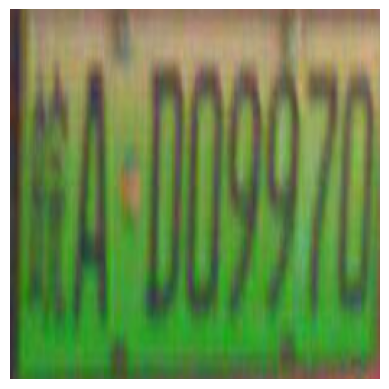

In [ ]:
#EDA
unnormalize = transforms.Normalize(
    mean=[-0.5 / 0.5],  # -mean / std
    std=[1.0 / 0.5]     # 1 / std
)

# Convert to PIL image
to_pil = transforms.ToPILImage()

# Example
img_tensor = tensor  
img_tensor = unnormalize(img_tensor)  # Unnormalize
img_pil = to_pil(img_tensor)         # Convert to PIL image

# show image
plt.imshow(img_pil, cmap='gray')
plt.axis('off')
plt.show()

# Network

In [47]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CRNN(num_classes=len(MY_DICTIONARY)+1).to(device)  # +1 per blank
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
ctc_loss = nn.CTCLoss(blank=BLANK_IDX, zero_infinity=True)


# Train

In [ ]:
NUM_EPOCHS = 20  # then change this, maybe a grid. will see
best_val_acc = 0.0
best_epoch = 0

for epoch in range(NUM_EPOCHS):
    print(f"Epoch {epoch+1}/{NUM_EPOCHS}")
    train_loss = train_one_epoch(model, dataloader_train, optimizer, ctc_loss, device)
    val_acc, val_acc_char = evaluate(model, dataloader_eval, device)
    print(f"Train Loss: {train_loss:.4f} | Val Accuracy (full plate): {val_acc:.4f}")
    print("-" * 40)
    
    # to save f acc gets better
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_epoch = epoch + 1
        torch.save(model.state_dict(), "best_crnn_ctc_model.pth")
        print(f"==> new model savced at epoch: {best_epoch} with acc {best_val_acc:.4f}")

print(f"Best model at epoch {best_epoch} with val acc {best_val_acc:.4f}")

Epoch 1/20
Epoch average loss: 3.3813
Eval accuracy (full plate): 0.0000 | Char accuracy: 0.0000
Train Loss: 3.3813 | Val Accuracy (full plate): 0.0000
----------------------------------------
Epoch 2/20
Epoch average loss: 1.8815
Eval accuracy (full plate): 0.0000 | Char accuracy: 0.1374
Train Loss: 1.8815 | Val Accuracy (full plate): 0.0000
----------------------------------------
Epoch 3/20
Epoch average loss: 1.7121
Eval accuracy (full plate): 0.0000 | Char accuracy: 0.1374
Train Loss: 1.7121 | Val Accuracy (full plate): 0.0000
----------------------------------------
Epoch 4/20


# Test

In [ ]:
# Test
print("Testing on test set:")
test_acc, test_acc_char = evaluate(model, dataloader_test, device)
print(f"Test Accuracy (full plate): {test_acc:.4f} | Char Accuracy: {test_acc_char:.4f}")


Testing on test set:
Eval accuracy (full plate): 0.0000
Test Accuracy (full plate): 0.0000


In [ ]:
#dunno what model is using in the cell above, reloading the best one

model.load_state_dict(torch.load("best_crnn_ctc_model.pth", map_location=device))

print("Testing on test set:")
test_acc = evaluate(model, dataloader_test, device)
print(f"Test Accuracy (full plate): {test_acc:.4f}")